<a href="https://colab.research.google.com/github/marianegri/Python_DataScience_MachineLearning/blob/main/Pre-processamento/TextAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install spacy pyLDAvis

In [2]:
# Pacote para trabalhar com portugues
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.2 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('punkt') ## tratamento de pontuação

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Conjunto de dados

In [5]:
news = pd.read_csv('https://www.dropbox.com/s/rvwjw8miow6jswy/articles.csv?dl=1')

In [6]:
news.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


Filtrar por turismo

In [7]:
turismo = news[news['category']=='turismo']

In [8]:
turismo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 381 to 167031
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1903 non-null   object
 1   text         1903 non-null   object
 2   date         1903 non-null   object
 3   category     1903 non-null   object
 4   subcategory  0 non-null      object
 5   link         1903 non-null   object
dtypes: object(6)
memory usage: 104.1+ KB


In [28]:
def limpa_texto(texto):
  c = re.sub(r'\n', ' ', texto)  # Sempre que encontrar um '\n' substitui por espaço na variavel texto
  c = re.sub(r'\r', ' ', c)      # Sempre que encontrar um '\r' substitui por espaço na variavel c

  c = c.replace(':', '')        # Sempre que encontrar um ':' substitui por vazio
  c = c.replace('/', '')        # Sempre que encontrar um '/' substitui por vazio
  c = re.sub(r'R\$', '', c)      # Sempre que encontrar um 'R\$' substitui por vazio na variavel c
  c = re.sub(r'\W', ' ', c)      # Sempre que encontrar um '\W' (ou seja, valores que não sejam alpha numericos) substitui por espaço na variavel c

  c = re.sub(r'\s+', ' ', c)     # Indentifica multiplos espaços e substitui por apenas 1 
  c = re.sub(r'^\s+', '', c)     # Inicio de frase com espaços. os espaços seram substituidos por vazio
  c = re.sub(r'\s+$', '', c)     # Fim de frase com espaços. os espaços seram substituidos por vazio

  return c.lower()     # Deixar o texto todo em letra minuscula

In [10]:
from spacy.lang.pt import Portuguese

In [11]:
STOP_WORDS = spacy.lang.pt.stop_words.STOP_WORDS # Palavras q foram definidas como palavras que podem ser tiradas do texto sem afetar

In [65]:
STOP_WORDS  # Caso precise tirar ou adicionar palavras, isso pode ser feito


{'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá',
 'd

In [13]:
def remove_stop(texto): ## tirar as palavras que estão na lista de STOP_WORDS
  doc = nlp_pt(texto)
  return " ".join(x.text for x in doc if x.text not in STOP_WORDS)

In [14]:
def limpa_texto2(texto):  ## Lematização : reduzir uma palavra à sua forma base e tira as palavras que estão na lista de stop words
  doc = nlp_pt(texto)
  return " ".join(x.lemma_ for x in doc if x.text not in STOP_WORDS)


# Análise Exploratória

1. Numero de palavras no titulo das noticias

In [15]:
turismo['title_n_words'] = turismo['title'].apply(lambda x : len(x.split()))

In [16]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10


In [17]:
turismo.describe()

,title_n_words
count,1903.000000
mean,10.923805
std,1.812440
min,4.000000
25%,10.000000
50%,11.000000
75%,12.000000
max,20.000000


2. Numero de caracteres no titulo das noticias

In [18]:
turismo['title_n_chars'] = turismo['title'].apply(lambda x : len(x.replace(" ", "")))

In [19]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62


In [20]:
turismo.describe()

,title_n_words,title_n_chars
count,1903.000000,1903.000000
mean,10.923805,55.666842
std,1.812440,6.309523
min,4.000000,25.000000
25%,10.000000,52.000000
50%,11.000000,57.000000
75%,12.000000,60.000000
max,20.000000,87.000000


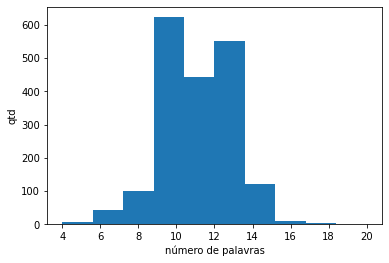

In [21]:
turismo.title_n_words.hist();
plt.xlabel('número de palavras')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

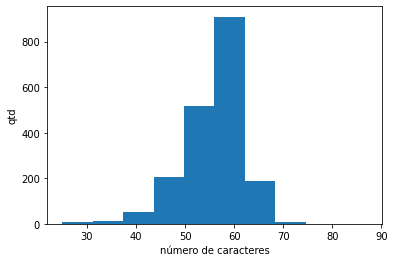

In [22]:
turismo.title_n_chars.hist();
plt.xlabel('número de caracteres')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

# Limpea dos dados

In [23]:
nlp_pt = spacy.load('pt_core_news_sm')

In [24]:
rev = turismo.iloc[0]['title'] # titulo da primeira linha do DF

In [25]:
rev

'Latam inaugura voo direto de 15 horas entre Chile e Austrália'

In [29]:
rev = limpa_texto(rev)

In [30]:
rev

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [31]:
rev2 = turismo.iloc[5]['title']

In [32]:
rev2

"'Viagem ao Japão é aula de cultura e tradição', diz ator Jayme Matarazzo"

In [33]:
limpa_texto(rev2)

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

In [34]:
rev = nlp_pt(rev)

In [38]:
def exibe_token(texto):
  col_names = ['ALPHA', 'PUNCT', 'LIKE NUM', 'POS']
  formatted_text = '{:>16}' * (len(col_names)+1)
  print('\n', formatted_text.format('INPUT WORD', *col_names), '\n', '='*130)

  for token in texto:
    output = [token.text, token.is_alpha, token.is_punct, token.like_num, token.pos_]
    print(formatted_text.format(*output))

In [39]:
exibe_token(rev)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
           latam               1               0               0            VERB
        inaugura               1               0               0            VERB
             voo               1               0               0            VERB
          direto               1               0               0             ADV
              de               1               0               0             ADP
              15               0               0               1             NUM
           horas               1               0               0            NOUN
           entre               1               0               0             ADP
           chile               1               0               0           PROPN
               e               1               0               0           CCONJ
       austrália               1               0               0           PROPN


In [41]:
from spacy import displacy

In [42]:
displacy.render(rev, style = 'dep', jupyter=True)

In [43]:
rev2 = nlp_pt(rev2)

In [44]:
exibe_token(rev2)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
               '               0               1               0           PUNCT
          Viagem               1               0               0            NOUN
               a               1               0               0             ADP
               o               1               0               0             DET
           Japão               1               0               0           PROPN
               é               1               0               0            VERB
            aula               1               0               0            NOUN
              de               1               0               0             ADP
         cultura               1               0               0            NOUN
               e               1               0               0           CCONJ
        tradição               1               0               0            NOUN
               '         

In [45]:
turismo['title_clean'] = turismo['title'].apply(lambda x : limpa_texto(x))

In [46]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...


In [47]:
turismo['title_clean_no_stop'] = turismo['title_clean'].apply(lambda x : remove_stop(x))

In [48]:
turismo.iloc[0]['title_clean']

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [49]:
turismo.iloc[0]['title_clean_no_stop']

'latam inaugura voo direto 15 horas chile e austrália'

In [50]:
# Lematiação

turismo['title_lemmas'] = turismo['title_clean_no_stop'].apply(lambda x : limpa_texto2(x))

In [53]:
turismo.iloc[0]['title_lemmas'] ## Entendeu latam como verbo latir

'latir inaugurar voar direto 15 horar chile e austrália'

In [52]:
turismo.iloc[5]['title_clean_no_stop']

'viagem a o japão aula cultura e tradição ator jayme matarazzo'

In [54]:
# N-grams
#Quais tokens são mais comuns?

In [55]:
titulos = " ".join(turismo['title_lemmas'])

In [56]:
token = word_tokenize(titulos)

In [57]:
bigrams = ngrams(token, 2)

In [59]:
print(Counter(bigrams).most_common(10))

[(('o', 'o'), 91), (('fotógrafo', 'registrar'), 39), (('atrair', 'turista'), 25), (('fotógrafo', 'clicar'), 23), (('álbum', 'viagem'), 22), (('companhia', 'aéreo'), 20), (('turista', 'o'), 20), (('o', 'turismo'), 20), (('viagem', 'o'), 18), (('e', 'o'), 18)]


In [60]:
trigrams = ngrams(token, 3)

In [61]:
print(Counter(trigrams).most_common(10))

[(('voltar', 'o', 'o'), 8), (('atrair', 'turista', 'o'), 7), (('fotógrafo', 'registrar', 'o'), 7), (('museu', 'dedicar', 'o'), 6), (('o', 'o', 'redor'), 6), (('o', 'o', 'mundo'), 6), (('o', 'o', 'público'), 6), (('viagem', 'o', 'o'), 5), (('fotógrafo', 'registrar', 'paisagem'), 5), (('o', 'redor', 'mundo'), 5)]


In [66]:
vectorizer = CountVectorizer(min_df=10, max_df = 0.9, stop_words=STOP_WORDS, lowercase=True)

In [67]:
data_vectorizer = vectorizer.fit_transform(turismo['title_lemmas'])

In [68]:
NUM_TOPICS = 2

In [69]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=30, learning_method='online', verbose=True)

In [70]:
data_lda = lda.fit_transform(data_vectorizer)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [72]:
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [73]:
pyLDAvis.enable_notebook()

In [74]:
dash = pyLDAvis.sklearn.prepare(lda, data_vectorizer, vectorizer, mds='tsne')

In [75]:
dash

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  51.450106
1      60.312561 -141.369141       2        1  48.549894, topic_info=           Term        Freq       Total Category  logprob  loglift
214     turista  188.000000  188.000000  Default  30.0000  30.0000
221      viagem  115.000000  115.000000  Default  29.0000  29.0000
213     turismo  114.000000  114.000000  Default  28.0000  28.0000
103   fotógrafo  102.000000  102.000000  Default  27.0000  27.0000
114       hotel  104.000000  104.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
182      região   22.124572   23.007021   Topic2  -4.8177   0.6835
34   brasileiro   39.140312   58.979457   Topic2  -4.2472   0.3125
162        país   36.391684   54.852547   Topic2  -4.3200   0.3123
88          eua   34.156518   60.760224   Topic2  -4.3834   0.1466
153       parir   26.086233   40.882032   Topic2  -4.6529   0.2733

[107 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2         1  0.049211       2015
2         2  0.984222       2015
6         1  0.972233      abrir
6         2  0.032408      abrir
7         1  0.044620  aeroporto
...     ...       ...        ...
234       1  0.054506        voo
234       2  0.981113        voo
238       1  0.976748       água
238       2  0.037567       água
239       2  0.968769      álbum

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])